# Measuring the Z boson mass


Let's look at a sample of $Z$ boson candidates recorded by CMS in 2011 and published at CERN opendata portal. It comes from DoubleMuon dataset with the following selection applied:

- Both muons are "global" muons
- invariant mass sits in range: 60 GeV < $ M_{\mu\mu}$ < 120 GeV
- |$\eta$| < 2.1 for both muons
- $p_{t}$ > 20 GeV

The following columns presented in the CSV file:

- `Run`, Event are the run and event numbers, respectively
- `pt` is the transverse momentum $p_{t}$ of the muon
- `eta` is the pseudorapidity of the muon: $\eta$
- `phi` is the $\phi$ angle of the muon direction
- `Q` is the charge of the muon
- `dxy` is the impact parameter in the transverse plane: $d_{xy}$ - how distant is the track from the collision point
- `iso` is the track isolation: $I_{track}$ - how many other tracks are there aroung given track

In [1]:
! pip install scikit-optimize

     |████████████████████████████████| 101 kB 4.1 MB/s 


In [2]:
!wget https://raw.githubusercontent.com/MohamedElashri/Hadron-Collider-ML/master/week1/Zmumu.csv 

--2021-08-16 19:19:22--  https://raw.githubusercontent.com/MohamedElashri/Hadron-Collider-ML/master/week1/Zmumu.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970550 (948K) [text/plain]
Saving to: ‘Zmumu.csv’

Zmumu.csv           100%[===================>] 947.80K  --.-KB/s    in 0.05s   

2021-08-16 19:19:22 (19.4 MB/s) - ‘Zmumu.csv’ saved [970550/970550]



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
%matplotlib inline

## Read dataset

In [4]:
df = pd.read_csv('./Zmumu.csv')
df.shape

(10000, 14)

Let's calculate the invariant mass $M$ of the two muons using the formula

$M = \sqrt{2p_{t}^{1}p_{t}^{2}(\cosh(\eta_{1}-\eta_{2}) - \cos(\phi_{1}-\phi_{2}))}$

In [5]:
df['M'] = np.sqrt(2 * df['pt1'] * df['pt2'] * (np.cosh(df['eta1'] - df['eta2']) - np.cos(df['phi1'] - df['phi2'])))
df.head(2)

,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2,M
0,165617,74969122,54.7055,-0.4324,2.5742,1,-0.0745,0.4999,34.2464,-0.9885,-0.4987,-1,0.0712,3.4221,89.885919
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.0000,28.5389,0.3852,-1.9912,1,0.0515,0.0000,88.812177


# Model

The distribution of the Z boson mass has the form of a normal distribution, in addition there is a noise. The distribution of the noise has an exponential form. Thus, the resulting model, it is a result of a superposition of two distributions - normal and polinomial

Let's plot the distribution of Z boson mass

In [6]:
def plot_mass(mass, bins_count=100):
    y, x = np.histogram(mass, bins=bins_count, density=False)
    err = np.sqrt(y)

    fig = plt.figure(figsize=(15,7))
    plt.title('Z mass', fontsize=20)
    plt.xlabel("$m_{\mu\mu}$ [GeV]", fontsize=20)
    plt.ylabel("Number of events", fontsize=20)
    plt.errorbar(x[:-1], y, yerr=err, fmt='o', color='red', ecolor='grey', capthick=0.5, zorder=1, label="data")
    return y, x

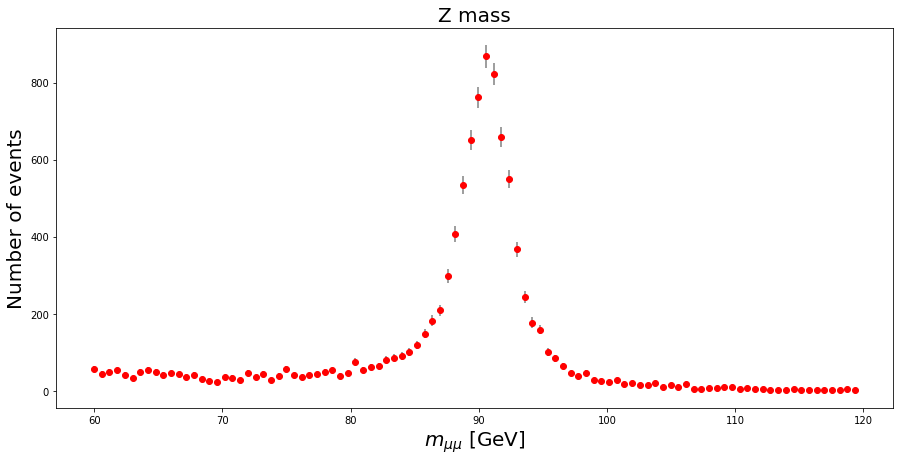

In [7]:
plot_mass(df.M);

## Exercise 1. clean up dataset a bit
- demand that charge of muons should be opposite
- $I_{track}$ < 3 and $d_{xy}$ < 0.2 cm

In [8]:
### YOUR CODE GOES HERE ###
df_sign = None #
df_isolation = None #
df = df

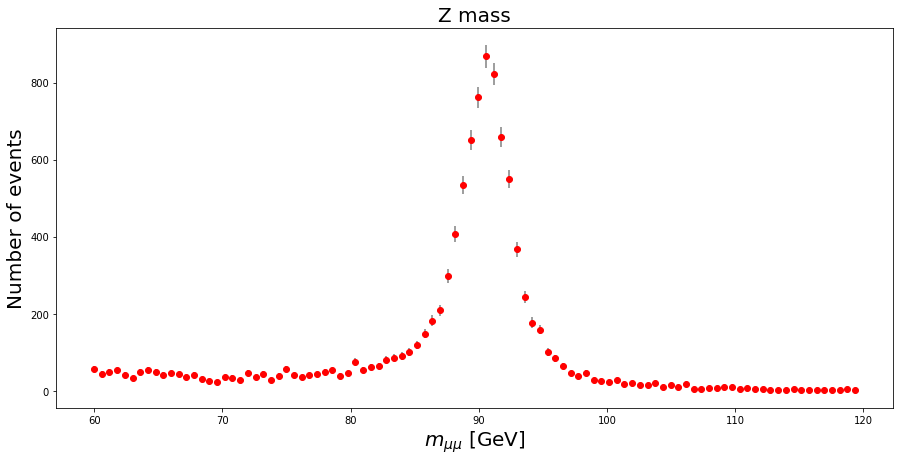

In [9]:
plot_mass(df.M);

### Let's define parametrised model
it should represent mixture of 1) Gaussian signal and 2) background that for the simplicity we consider to be flat over mass. So it gives the following set of parameters:

- m0 - center of the Gaussian
- sigma - standard deviation of the Gaussian
- ampl - height of the peak
- bck - height of the background 

finding those parameters is called _fitting_ model into the data. It will be the goal for the rest of the exercise. For simplicity sake we'll stick with old good binned fit.

In [10]:
def model_predict(params, X):
    m0, sigma, ampl, bck = params
    return bck + ampl / (sigma * np.sqrt(2 * np.pi)) * np.exp((-1) * (X - m0)**2 / (2 * sigma**2))

In [11]:
def model_loss(params, X, y):
#     y, x = np.histogram(mass, bins=bins_count, density=False)
#     residuals = model_predict(params, (x[1:] + x[:-1])/2) - y 
    residuals = y - model_predict(params, X)
    return np.sum(residuals**2) / len(residuals)

In [12]:
def plot_mass_with_model(params, mass, bins_count=100):
    y, X = plot_mass(mass, bins_count=bins_count)
    X = (X[1:] + X[:-1]) / 2
    error = model_loss(params, X, y)
    plt.plot(X, model_predict(params, X), color='blue', linewidth=3.0, zorder=2, label="fit, loss=%.2f" % error)
    plt.legend(fontsize='x-large')

## Here you can fit model parameters by hand

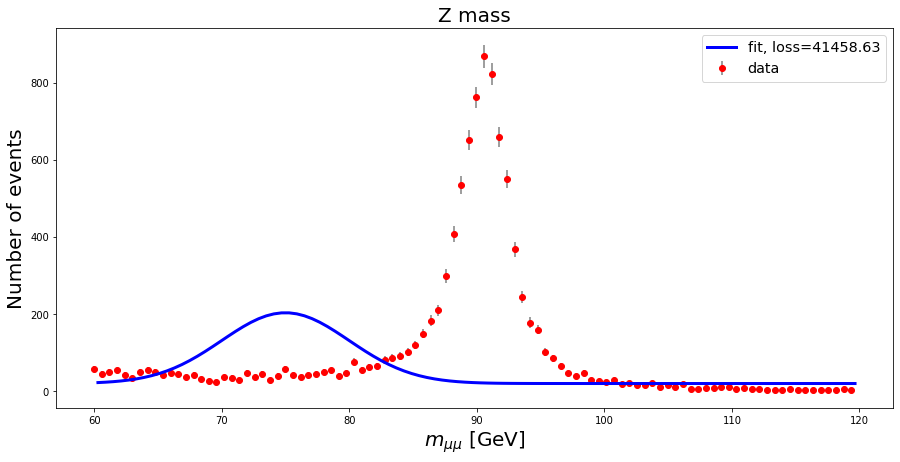

In [13]:
plot_mass_with_model((75, 5, 2300, 20), df.M)


## ... but you can do it automatically of course

Setting up a scikit optimizer

In [14]:
from tqdm import tqdm
from skopt import Optimizer

search_space = [(90.0, 93.0), # m0 range
    (0.5, 10.0), # sigma range
    (2900, 2925), # amplitude range
    (0, 50) # bck range
    ]
y, X = np.histogram(df.M, bins=120, density=False)
X = (X[1:] + X[:-1]) / 2
opt = Optimizer(search_space, base_estimator="GP", acq_func="EI", acq_optimizer="lbfgs")


Running it for a while. You can re-run this cell several times

In [15]:
from skopt.utils import create_result
for i in tqdm(range(50)):
    next_x = opt.ask()
    f_val = model_loss(next_x, X, y)
    opt.tell(next_x, f_val)
    
res = create_result(Xi=opt.Xi, yi=opt.yi, space=opt.space,
                         rng=opt.rng, models=opt.models)


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


## A bit of search history

[('m0', 91.14704485747508), ('sigma', 1.9688675854503008), ('ampl', 2917), ('bck', 22)]


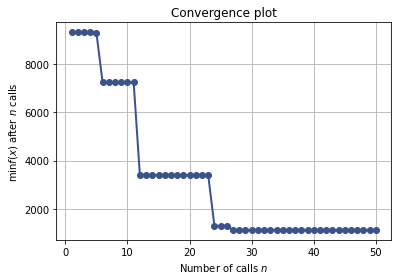

In [16]:
import skopt.plots
skopt.plots.plot_convergence(res)
print (list(zip(["m0", "sigma", "ampl", "bck"], res.x)))


In [17]:
# even more details on the search space
# skopt.plots.plot_objective(res, dimensions=['m0', 'sigma', 'ampl', 'bck'])


Let's see how well the prediction fits the data

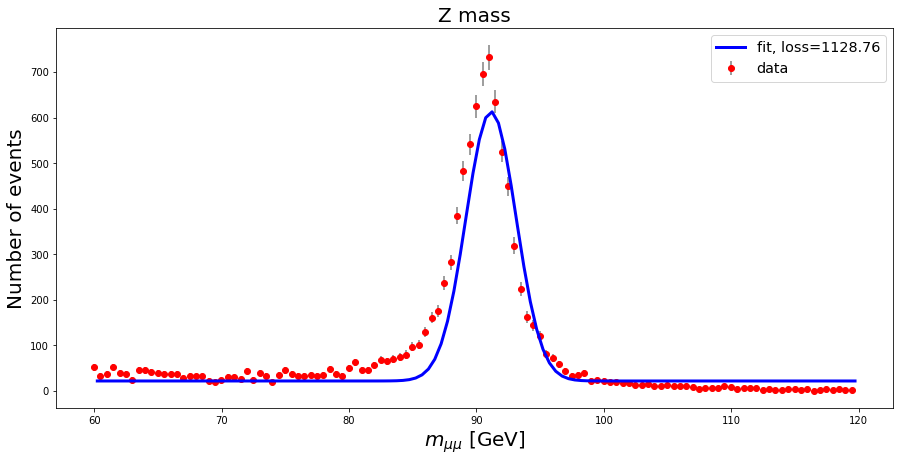

In [18]:
plot_mass_with_model(res.x, df.M, bins_count=120)

In [19]:
# token expires every 30 min
COURSERA_TOKEN = "NWKs3djb01JU66MM"### YOUR TOKEN HERE
COURSERA_EMAIL = "Armanbehnam1996@gmail.com"### YOUR EMAIL HERE

In [22]:
import requests
import json

class Grader(object):
    
    def __init__(self, assignment_key, all_parts=()):
        """
        Assignment key is the way to tell Coursera which problem is being submitted.
        """
        self.submission_page = \
            'https://www.coursera.org/api/onDemandProgrammingScriptSubmissions.v1'
        self.assignment_key = assignment_key
        self.answers = {part: None for part in all_parts}
        
    def set_answer(self, part, answer):
        """
        Adds an answer for submission. Answer is expected either as string, number, or
        an iterable of numbers.
        Args:
            part - str, assignment part id
            answer - answer to submit. If non iterable, appends repr(answer). If string,
            is appended as provided. If an iterable and not string, converted to
            space-delimited repr() of members.
        """
        if isinstance(answer, str):
            self.answers[part] = answer
        else:
            try:
                self.answers[part] = " ".join(map(repr, answer))
            except TypeError:
                self.answers[part] = repr(answer)    
    
    def submit(self, email, token):
        submission = {
                    "assignmentKey": self.assignment_key, 
                    "submitterEmail": email, 
                    "secret": token, 
                    "parts": {}
                  }
        for part, output in self.answers.items():
            if output is not None:
                submission["parts"][part] = {"output": output}
            else:
                submission["parts"][part] = dict()
        request = requests.post(self.submission_page, data=json.dumps(submission))
        response = request.json()
        if request.status_code == 201:
            print('Submitted to Coursera platform. See results on assignment page!')
        elif u'details' in response and u'learnerMessage' in response[u'details']:
            print(response[u'details'][u'learnerMessage'])
        else:
            print("Unknown response from Coursera: {}".format(request.status_code))
            print(response)
grader = Grader(assignment_key="SeMsm2JfEeiyvBKA0wfIgA", 
                      all_parts=["VI3xu", "VuE8x", "KzmMV", "TwZBF"])

In [23]:
ans_part1 = round(res.x[0])
grader.set_answer("VI3xu", ans_part1)

ans_part2 = round(res.x[1], 2)
grader.set_answer("VuE8x", ans_part2)

ans_part3 = round(res.x[3])
grader.set_answer("KzmMV", ans_part3)

ans_part4 = round(res.x[2])
grader.set_answer("TwZBF", ans_part4)

grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
